## Knowledge Base RAG

进入 02_Knowledge_Base_lambda

新建terminal, 运行：

sudo yum update -y
sh init.sh
pip3 install -r requirements.txt


npm install ts-node --save-dev
npm install typescript -g
npm install typescript --save-dev


cdk bootstrap

运行cdk deploy --all

看到返回SmartCrawlerStack.BucketName = smartcrawlerstack-knowledgebasebucket...

进入lambda, 寻找SmartCrawlerStack-GenAICrawlerFunction。

增加环境变量SERPAPI_API_KEY 数值为： 4146f24259aae065b1adbd64437157a2dc3c46a02a41ecc834118b785aafd513

配置测试事件
{
  "query": "amazon 研报"
}

点击测试，确认运行完成。进入s3 smartcrawlerstack-knowledgebasebucket 确认有文件返回。

创建knowledge base

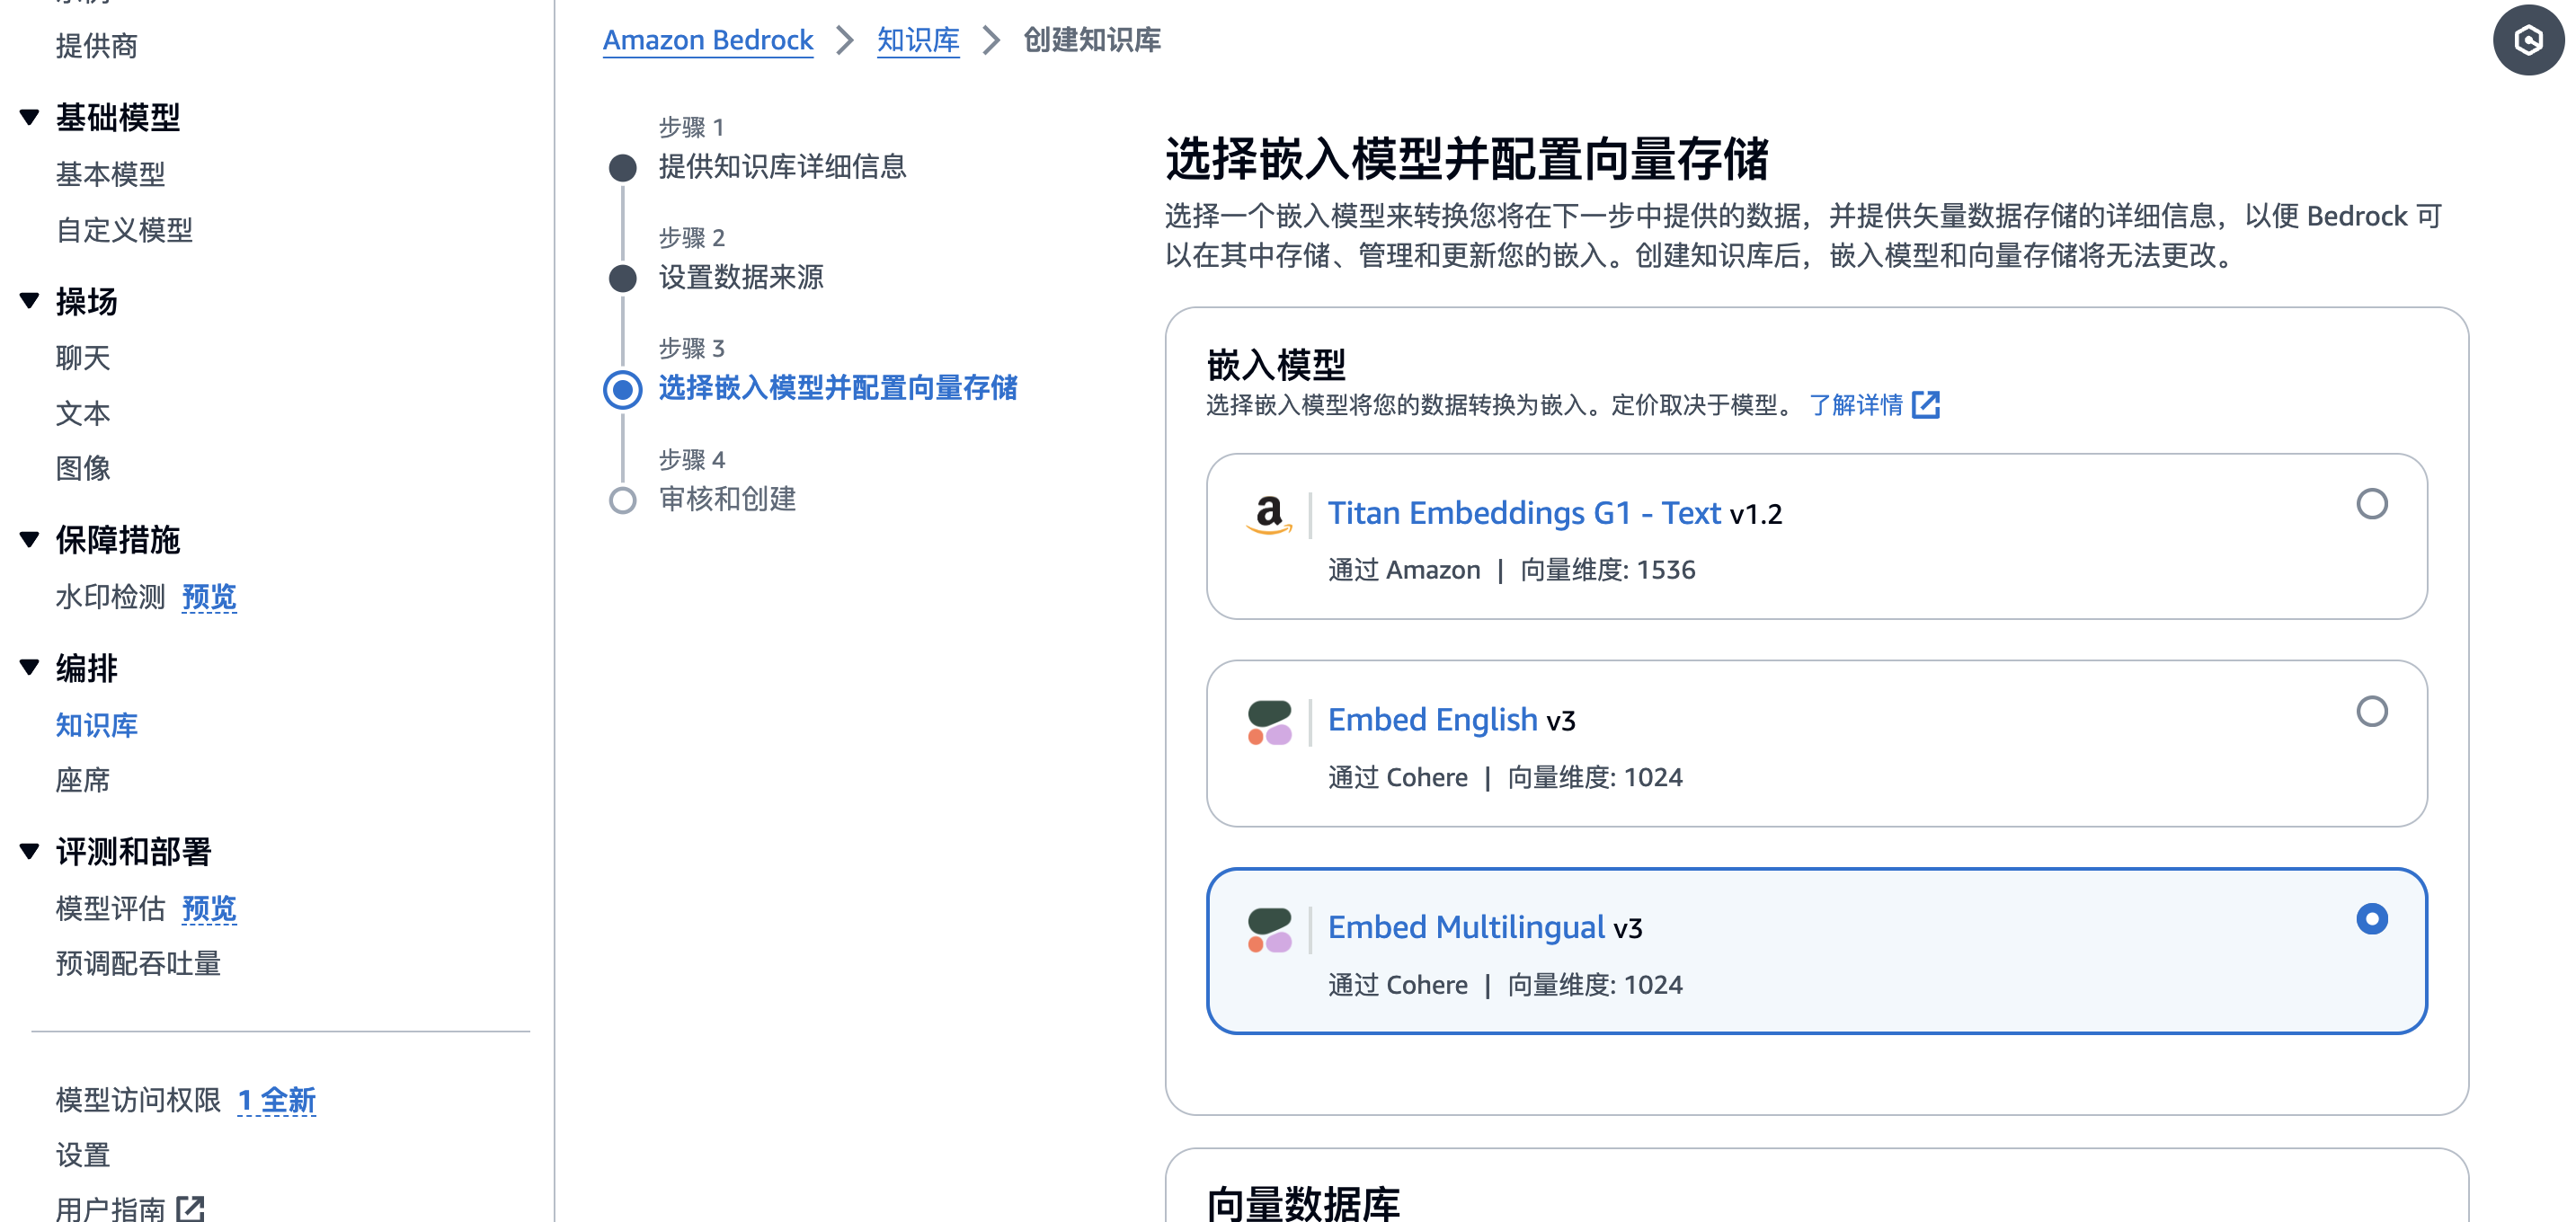
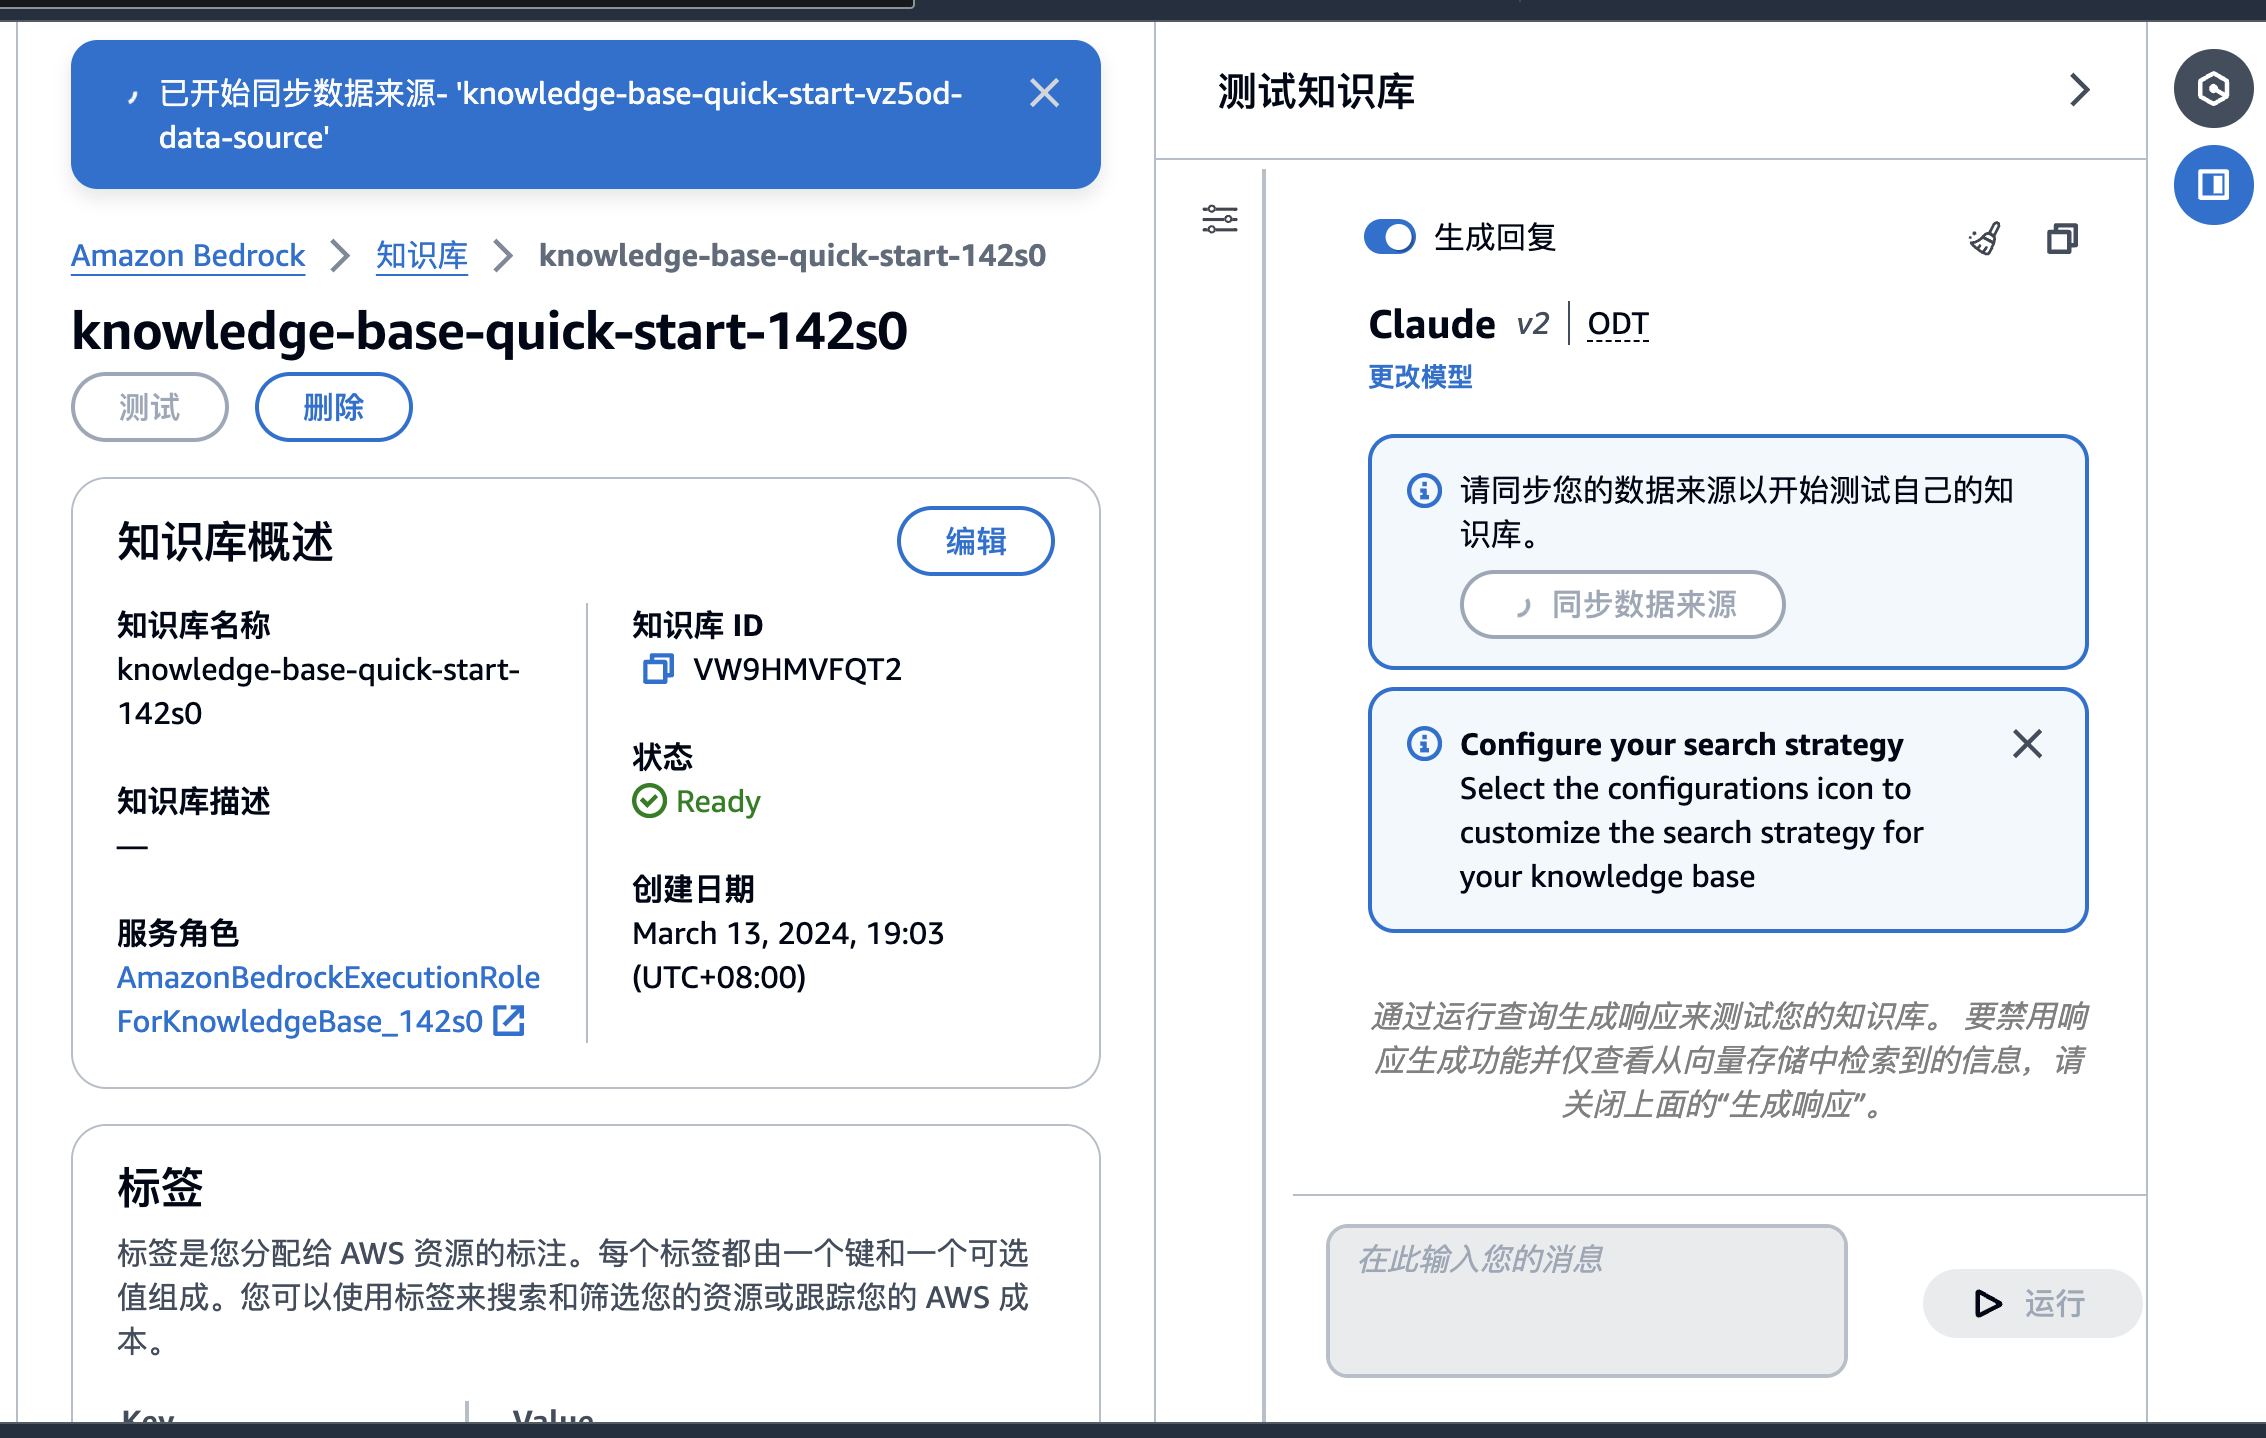

在线提问：亚马逊主营业务是什么？
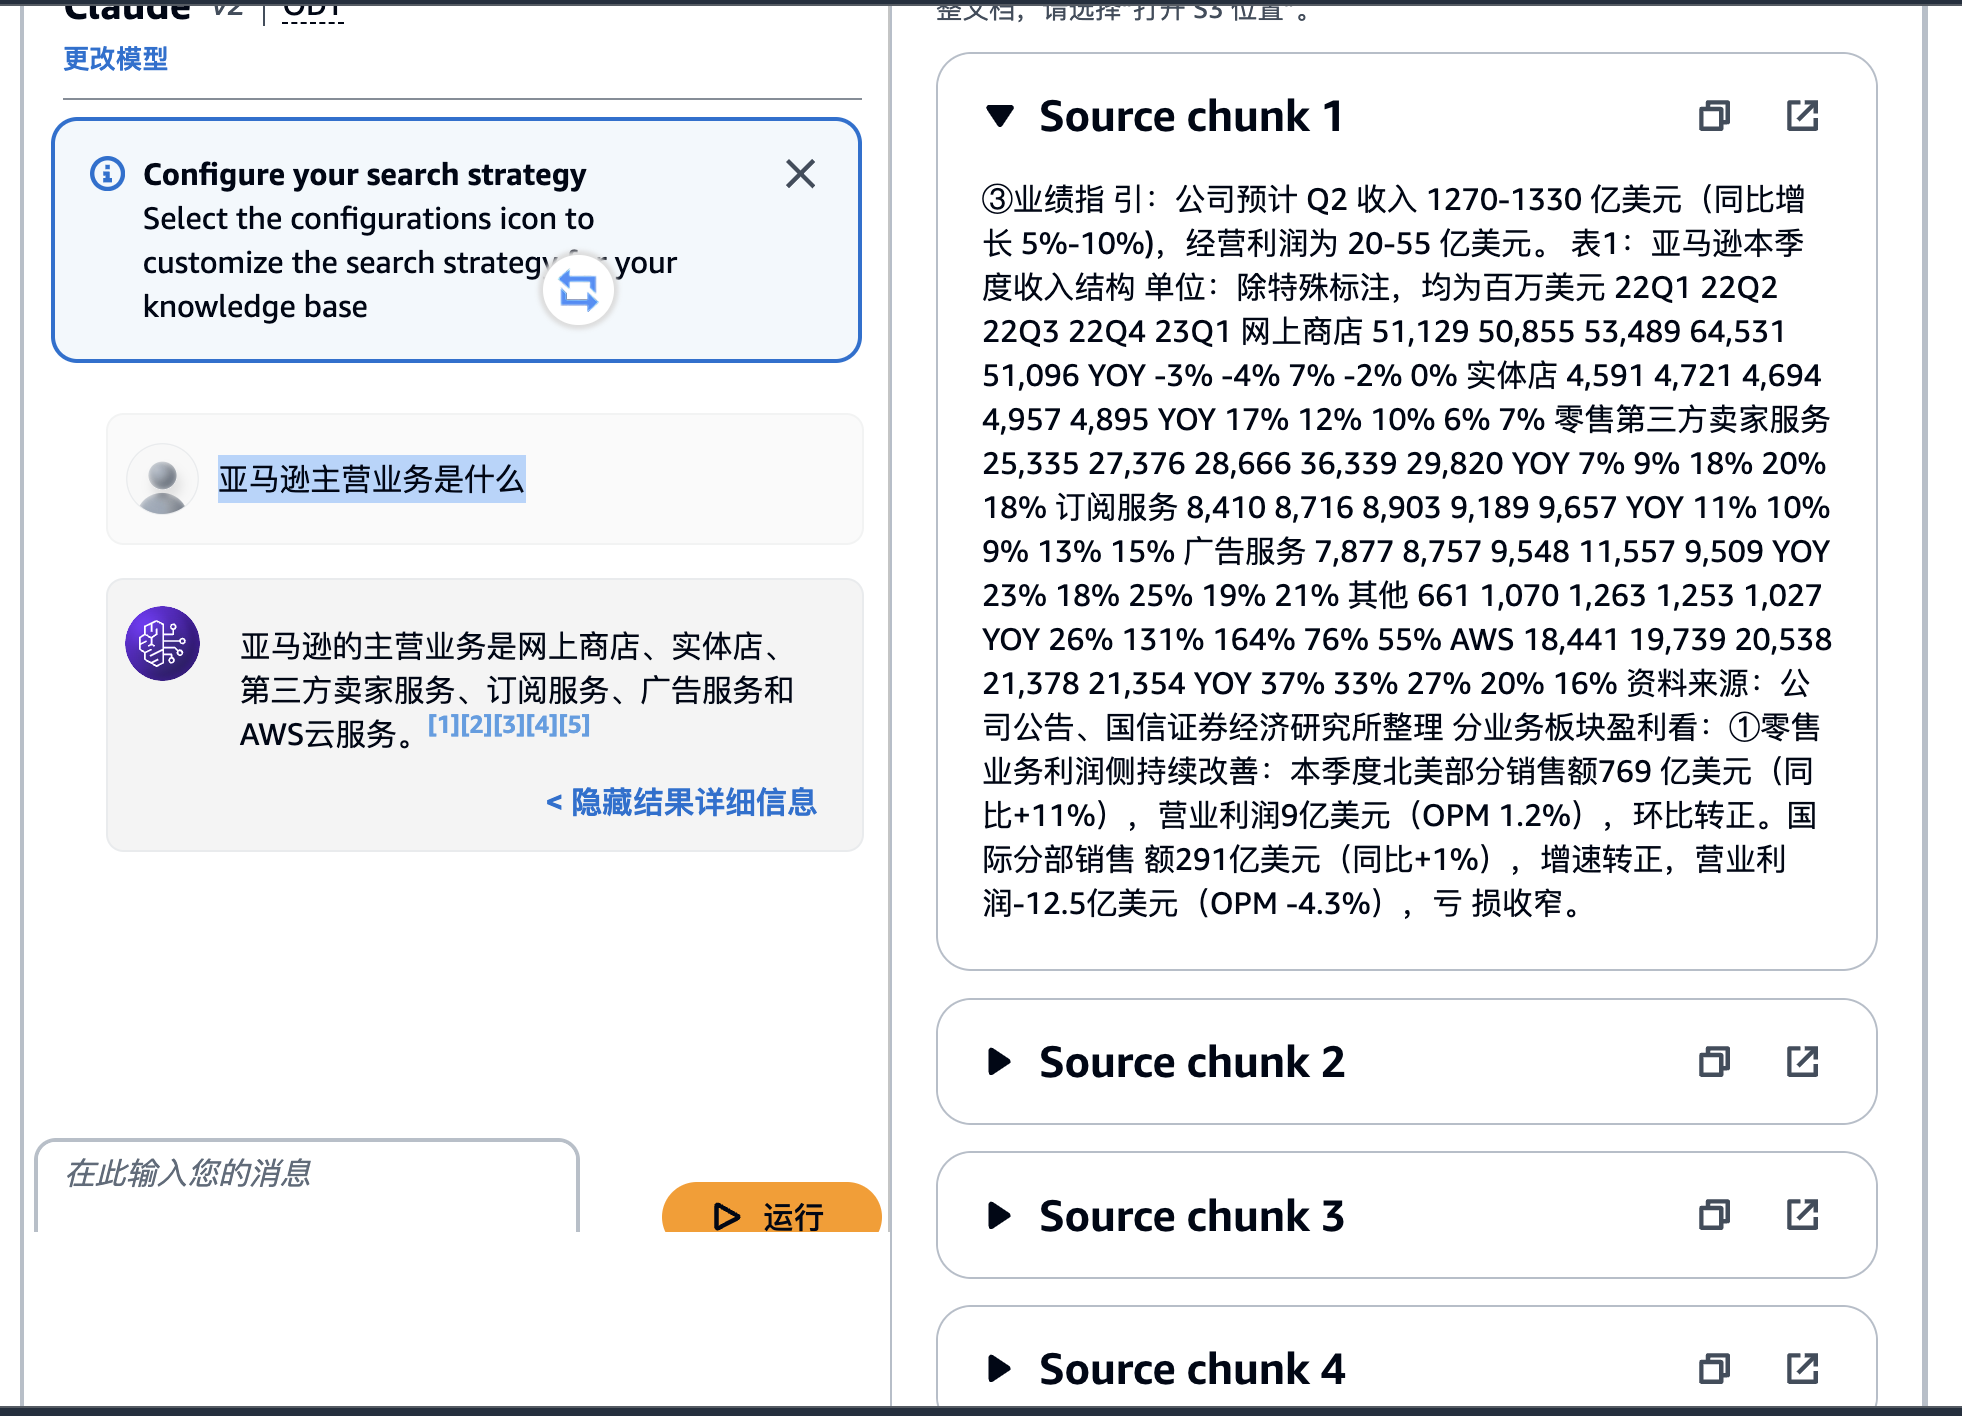

# sdk测试

In [1]:
import boto3
import pprint
from botocore.client import Config
from langchain.llms.bedrock import Bedrock

pp = pprint.PrettyPrinter(indent=2)

bedrock_config = Config(connect_timeout=120, read_timeout=120, retries={'max_attempts': 0})
bedrock_client = boto3.client('bedrock-runtime')
bedrock_agent_client = boto3.client("bedrock-agent-runtime",
                                    config=bedrock_config)

model_kwargs_claude = {
                            "temperature": 0,
                            "top_k": 10,
                            "max_tokens_to_sample": 3000
                        }

llm = Bedrock(model_id="anthropic.claude-v2",
              model_kwargs=model_kwargs_claude,
              client = bedrock_client,)

### Retrieve API: Process flow 

Define a retrieve function that calls the `Retreive API` provided by Knowledge Bases for Amazon Bedrock which converts user queries into
embeddings, searches the knowledge base, and returns the relevant results, giving you more control to build custom
workﬂows on top of the semantic search results. The output of the `Retrieve API` includes the the `retrieved text chunks`, the `location type` and `URI` of the source data, as well as the relevance `scores` of the retrievals. 

![retrieveAPI](./images/retrieveAPI.png)



In [2]:
def retrieve(query, kbId, numberOfResults=5):
    
    response = bedrock_agent_client.retrieve(
                                                retrievalQuery= {
                                                    'text': query
                                                },
                                                knowledgeBaseId=kbId,
                                                retrievalConfiguration= {
                                                    'vectorSearchConfiguration': {
                                                        'numberOfResults': numberOfResults
                                                    }
                                                }
                                            )
    
    return response

#### 替换知识库 ID


In [3]:
kb_id = "LCJCAQMBZA" 

In [4]:
query = "亚马逊2023年营收?"
response = retrieve(query, kb_id, 3)
retrievalResults = response['retrievalResults']
pp.pprint(retrievalResults)

[ { 'content': { 'text': '同时 AWS 作为占据了全球 30%以上的市场份额的   '
                         '龙头，面临着市场饱和、竞争加剧的双重压力。但通过亚马逊在 AI 领域包括   '
                         '算力、平台、应用的布局有望增益云业务竞争力与商业价值。③AI 有望进一步   '
                         '降低零售运营成本，提升用户体验，打开新的增长空间。凭借 AI 技术的突破   '
                         '与亚马逊自身拥有海量用户数据流量，亚马逊有望提升相关业务服务质量和利   '
                         '润率。对于零售业务端可以进行精准营销、更智能的客户服务、提升存储物流   等运营效率，对于 3P '
                         '卖家服务和广告订阅业务可以进行高效的营销和娱乐内   容生成、提升履约效率、降低履约成本。   '
                         '财报概览：亚马逊2023Q1整体财务表现稳健，但云业务指引偏弱。①整体：在2023   '
                         '年第一季度，亚马逊实现了营收1274亿美元，同比增长9%，毛利率42.6%，营业利   '
                         '润48亿美元（同比+30%，OPM3.7%），净利润32亿美元（上年同期为净亏损38亿   '
                         '美元），扭亏为盈。②分业务看:零售版块,线上自营零售收入 511 亿美元（同比   持平），线下零售收入 '
                         '49 亿美元（同比+7%），第三方卖家服务收入 298 亿美   元（同比+18%），订阅服务收入 97 '
                         '亿美元（同比+15%），广告收入 95 亿美元   （同比+21%）,云业务版块，AWS 云业务收入 '
                         '214 亿元（同比+16%）。③业绩指   引：公司预计 Q2 收入 1270

In [5]:
from langchain.prompts import PromptTemplate

PROMPT_TEMPLATE = """
                    Human: You are a financial advisor AI system, and provides answers to questions by using fact based and statistical information when possible. 
                    Use the following pieces of information to provide a concise answer to the question enclosed in <question> tags. 
                    If you don't know the answer, just say that you don't know, don't try to make up an answer.
                    <context>
                    {context_str}
                    </context>

                    <question>
                    {query_str}
                    </question>

                    The response should be specific and use statistics or numbers when possible.

                    Assistant:"""

claude_prompt = PromptTemplate(template=PROMPT_TEMPLATE, 
                               input_variables=["context_str","query_str"])

In [6]:
# fetch context from the response
def get_contexts(retrievalResults):
    
    contexts = []
    for retrievedResult in retrievalResults: 
        contexts.append(retrievedResult['content']['text'])
        
    return contexts

In [7]:
contexts = get_contexts(retrievalResults)
pp.pprint(contexts)

[ '同时 AWS 作为占据了全球 30%以上的市场份额的   龙头，面临着市场饱和、竞争加剧的双重压力。但通过亚马逊在 AI 领域包括   '
  '算力、平台、应用的布局有望增益云业务竞争力与商业价值。③AI 有望进一步   降低零售运营成本，提升用户体验，打开新的增长空间。凭借 AI '
  '技术的突破   与亚马逊自身拥有海量用户数据流量，亚马逊有望提升相关业务服务质量和利   '
  '润率。对于零售业务端可以进行精准营销、更智能的客户服务、提升存储物流   等运营效率，对于 3P 卖家服务和广告订阅业务可以进行高效的营销和娱乐内   '
  '容生成、提升履约效率、降低履约成本。   财报概览：亚马逊2023Q1整体财务表现稳健，但云业务指引偏弱。①整体：在2023   '
  '年第一季度，亚马逊实现了营收1274亿美元，同比增长9%，毛利率42.6%，营业利   '
  '润48亿美元（同比+30%，OPM3.7%），净利润32亿美元（上年同期为净亏损38亿   美元），扭亏为盈。②分业务看:零售版块,线上自营零售收入 '
  '511 亿美元（同比   持平），线下零售收入 49 亿美元（同比+7%），第三方卖家服务收入 298 亿美   元（同比+18%），订阅服务收入 '
  '97 亿美元（同比+15%），广告收入 95 亿美元   （同比+21%）,云业务版块，AWS 云业务收入 214 亿元（同比+16%）。③业绩指   '
  '引：公司预计 Q2 收入 1270-1330 亿美元（同比增长 5%-10%)，经营利润为 20-55   亿美元。',
  '\uf06c AI 技术还可以帮助其他业务实现更广泛的应用场景和合作伙伴，如通过使用人工   '
  '智能、物联网（IoT）、区块链（Blockchain）等技术，打造 Amazon Dash Button   （购物实体按钮）、Ring Alarm '
  'Keypad（家庭安防产品）、Ring Fetch（宠   物追踪器）等应用场景和合作伙伴，提供更便捷的购物方式、更安全的家庭环境。   \uf06c '
  'AI 技术在无人驾驶方面可以降低运输成本和安全事故率。亚马逊获得加州机   动车辆管理局颁发的 Zoox 无人驾驶测试许可。凭借此许可证，Zoox '
  '已经完

In [8]:
import json
prompt = claude_prompt.format(context_str=contexts, 
                              query_str=query)


In [9]:
response = llm(prompt)
print(response)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


 <question>
亚马逊2023年营收?
</question>

根据提供的信息,我无法直接得出亚马逊2023年的具体营收数字。信息中提到亚马逊在2023年第一季度实现了营收1274亿美元,同比增长9%。公司预计第二季度收入1270-1330亿美元,同比增长5%-10%。但信息中没有给出整年的营收预测。所以我无法直接回答2023年亚马逊的具体营收是多少。抱歉,我不知道具体的答案。
